In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


The Freundlich adsorption model represents the multilayer adsorption of an adsorbent on a solid surface and is represented by the function (1).



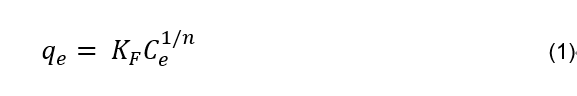

Ce is the concentration of As(III) in solution at equilibrium,qe is the concentration of As(III) in the adsorbent when the reaction reaches equilibrium and KF is the Freundlich constant, and n is experimentally determined constants


Combining predictive models of adsorption isotherms and adsorption kinetics to form an improved pseudo-second-order model for predictive modelling (shown in Function (2)). Furthermore, comparing the two modelling methods of batch and continuous treatment, the best solution, and suitable adsorbent concentration is found. 

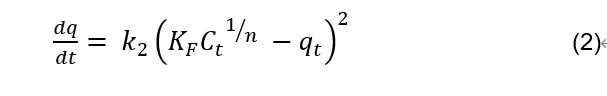

qe is the concentration of As(III) in the adsorbent when the reaction reaches equilibrium, qt is the quantity of arsenic adsorbed at time t,Ct is the concentration of aqueous As(III) at time t and k2 is the pseudo-second-order rate constant. 


Function (3) shows the equation for the reactor design model for continuous treatment.

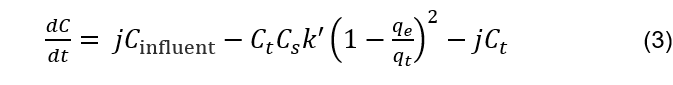

Where k’ is the rate constant,  Cs is sorbent concentrations,  j is the reactor turnover rate  and C_influent is the inflow As(III) concentration 


In [ ]:
def DiffEq(d_list,t):

  time=t;

  j = exp[0,2];          # the reactor turnover rate 
  Cinfluent = exp[0,3];        # the inflow As(III) concentration 
  k = exp[0,4];           # rate constant
  Cs = exp[0,5];           # sorbent concentrations
  KF = exp[0,6];          # Freundlich constant
  n = exp[0,7];           # experimentally determined constants
  Qmax = exp[0,8];
  KL = exp[0,9];               
  isotherm=exp[0,10]
  order=exp[0,11] 
  Figure=exp[0,12]


  Ct,qt = d_list          # concentration of aqueous As(III) and the quantity of arsenic adsorbed at time t 
  if Ct<0.001:
    Ct=0.001           #set a minimum concentration of sorbate in the reactor to prevent the Freundlich adsorption isotherm from running an error.

  if Ct>=Cinfluent:
      Ct=Cinfluent      #control incase ode15s time intervals are too large

  
  Ct_mgL = Ct/1000         
  qt_mgg = qt/(Cs*1000)   
  if isotherm==1:
    # Freundlich
    rate_ads = 1000*k*Ct_mgL*Cs*((1-(qt_mgg/(KF*(Ct_mgL**(1/n)))))**order)  # batch treatment reactor design
 
  elif isotherm==2:
    # Langmuir
    rate_ads= 1000*k*Ct_mgL*Cs*((1-(qt_mgg/((Qmax*KL*Ct_mgL)/(1+KL*Ct_mgL))))**order) 
  
  
  rate_influx = j*Cinfluent;            #calculate the rate of sorbate influx (continuous-flow systems only)
  rate_outflux = j*Ct;               #calculate the rate of sorbate outflux (continuous-flow systems only)
  dCdt=[0,0];
  dCdt[0]=-rate_ads+rate_influx-rate_outflux      #continuous treatment reactor design 
  
  if Figure==True:
    
    dCdt[1] = rate_ads /Cs*1000
  elif Figure==False:
   
    dCdt[1] = rate_ads 

  return dCdt


Differential equations are equations containing unknown functions and their derivatives. ODEs are Ordinary Differential Equations (ODEs) with only one independent variable

scipy.integrate.odeint() is a specific method for solving differential equations, solving systems of ordinary differential equations by numerical integration

In [ ]:
def Result_Processing (j_flow,C_inf,Cs0,figure=True,ord_in=2,isotherms="Freundlich",
                       k_in=0.1111,KF_in=5.10,n_in=2.63,
                       Qmax_in=29.44,KL_in=0.11):
  

  number_of_experiments=1  #each experiment will have a different initial sorbate concentration (C0) 实验次数
 
  number_of_variables = 13            #counting how many rows in the array we need to store the input parameters for each kinetic plot 参数数量

  experiments = np.zeros((number_of_experiments,number_of_variables))  #each experiment refers to a single kinetic plot  54*8的矩阵（行为第几次试验，列表示参数）


  if isotherms=="Freundlich":
    isoth_in=1
  elif isotherms=="Langmuir":
    isoth_in=2

  #creating the input variables for each kinetic plots

  C_init =0.01;     # ug L-1  - this is the initial concentration of aqueous sorbate in the suspension 这是悬浮液中山梨醇水溶液的初始浓度

  q_init = 0;       # ug L-1  - this is the initial concentration of adsorbed sorbate in the suspension 吸收AS的浓度

  Cs = Cs0;        #g L-1 - this is the concentration of sorbent  吸附剂浓度

  Cinfluent = C_inf;    # ppb or ug L-1 - this is the concentration of sorbate in the influent (for continuous-flow modelling)

  j = j_flow;          #this the turn-over frequency, i.e. bed volumes per minute

  k = k_in;     #this is the value of normalised k' (L g-1 min-1)

  KF = KF_in;      #this is the Freundlich constant (mg g-1) used to determine 'qe' at each time step

  n = n_in;       #this is the second parameter for the Freundlich adsorption isotherm (g L-1) used to determine 'qe' at each time step
  
  Figure=figure

  Qmax = Qmax_in

  isotherm=isoth_in

  order=ord_in

  KL=KL_in


  #setting the time intervals upon which data is recorded. This will be
  #overwritten later to avoid wasting computational time after breakthrough
  #has already occurred.

  t_end = 1000000;   #1440 = 1 day
  t_steps = 20000;
  t_step = t_end/t_steps;
  bv_end = t_end*j;
  tt=list(np.arange(0,t_end+1,t_step))  

  results_table=[0]*number_of_experiments
  

  for i in range(number_of_experiments) :
    experiments[i,0] = C_init;
    experiments[i,1] = q_init;
    experiments[i,2] = j;
    experiments[i,3] = Cinfluent;
    experiments[i,4] = k;
    experiments[i,5] = Cs; #exponentially increasing sorbent concentration
    experiments[i,6] = KF;
    experiments[i,7] = n;  
    experiments[i,8] = Qmax
    experiments[i,9] = KL  
    experiments[i,10] = isotherm
    experiments[i,11] = order
    experiments[i,12] = Figure    


  for i in range(number_of_experiments): 
    global exp 
    exp = np.zeros((1,number_of_variables));
     
    exp[0,:] = experiments[i,:]
    exp_C_init = exp[0,0]
    exp_q_init = exp[0,1]
    t_end = 180000 * exp[0,5] / (exp[0,2] * exp[0,3]);  # 50000*Cs/(j*Cinf)
    if t_end<1000:
        t_end = t_end*20
    
    if t_end<500:
        t_end=t_end*5
    
    if j<0.01:
        t_end=t_end*10
    
    if Figure==True:
      stepping = [i for i in range(t_steps+1)]     #collect data at shorter time intervals in the initial stages of the simulation
      stepping[0]=0
      gradient_1=1
      gradient_2=30
      for j in range(1,(t_steps+1)) :
      #change the time intervals from being evenly spaced to having a smooth
      #transition from gradient_1 to gradient_2
        stepping[j]=stepping[j-1]+(gradient_2*(stepping[j]/t_steps))+(gradient_1*((t_steps-stepping[j])/t_steps))
    
      for k in range(1,(t_steps+1)):
          #normalise the time intervals to 1 and then multiply out by the desired
          #final time
          stepping[k]=(stepping[k]/stepping[-1])*t_end;
      #result = odeint(DiffEq,[exp_C_init,exp_q_init],stepping)     
    elif Figure==False:
      stepping=[i for i in range(0,525600,1440)]
    
    
    result = odeint(DiffEq,[exp_C_init,exp_q_init],stepping,rtol=1e-6)
      
    
    counter=0
    results_Ct=np.zeros((number_of_experiments,len(result[:,0])))
    results_t=np.zeros((number_of_experiments,len(stepping)))
    results_t[i,:] = stepping
    results_Ct[i,:] = result[:,0]

    for j in range(len(result[:,0])):
         if result[:,0][j]<=10.5:
           counter+=1

    results_table[i] = [results_t[i,:],results_Ct[i,:]]
  return results_table,counter

### The section 1
This section compares the change in arsenic concentration in liquid with a rate constant equal to 0.111, an adsorption capacity equal to 5.1 and an arsenic concentration of 500 and turn overate is equal to 0.1 in liquid as the adsorbent concentration is varied.

In [ ]:
results_table_10000_5,_=Result_Processing (0.1,500,10000)
results_table_1000_5,_=Result_Processing (0.1,500,1000)
results_table_100_5,_=Result_Processing (0.1,500,100)
results_table_10_5,_=Result_Processing (0.1,500,10)
results_table_1_5,_=Result_Processing (0.1,500,1)

### The section 2
This section compares the change in arsenic concentration in liquid with a rate constant equal to 0.111, an adsorption capacity equal to 5.1 and an arsenic concentration of 2000 and turn overate is equal to 0.1 in liquid as the adsorbent concentration is varied.

In [ ]:
results_table_10000,_=Result_Processing (0.1,2000,10000)
results_table_1000,_=Result_Processing (0.1,2000,1000)
results_table_100,_=Result_Processing (0.1,2000,100)
results_table_10,_=Result_Processing (0.1,2000,10)
results_table_1,_=Result_Processing (0.1,2000,1)

### The section 3
Under the conditions of influent concentration is equal to 2000, inital sorbent concentration is equal to 1000 , the adsorption capacity equal to 5.1 and the turnover rate is equal to 0.1, vary the rate constant within the margin of error and observe the effect on the concentration of arsenic in the solution (0.111 +/- 0.06)



In [ ]:
results_rc_0111,_=Result_Processing (0.1,2000,1000,k_in=0.111)


results_rc_0171,_=Result_Processing (0.1,2000,1000,k_in=0.171)


results_rc_0051,_=Result_Processing (0.1,2000,1000,k_in=0.051)


### The section 4

Under the conditions of influent concentration is equal to 2000, inital sorbent concentration is equal to 1000, rate constant equal to 0.111 and the turnover rate is equal to 0.1, vary the Freundlich parameters within the margin of error and observe the effect on the concentration of arsenic in the solution (5.10 +/- 1.0)

In [ ]:
results_F_510,_=Result_Processing (0.1,2000,1000,KF_in=5.10)


results_F_410,_=Result_Processing (0.1,2000,1000,KF_in=4.10)


results_F_610,_=Result_Processing (0.1,2000,1000,KF_in=6.10)

### The section 5

Under the conditions of influent concentration is equal to 2000, inital sorbent concentration is equal to 1000 , the adsorption capacity equal to 5.1 and rate constant equal to 0.111, vary the parameter n within the margin of error and observe the effect on the concentration of arsenic in the solution (2.63 +/- 1.2)

In [ ]:
results_n_143,_=Result_Processing (0.1,2000,1000,n_in=1.43)


results_n_263,_=Result_Processing (0.1,2000,1000,n_in=2.63)


results_n_383,_=Result_Processing (0.1,2000,1000,n_in=3.83)

### The section 6
Under the conditions of influent concentration is equal to 2000, inital sorbent concentration is equal to 1000 and the turnover rate is equal to 0.1, vary the turnover rate within the margin of error and observe the effect on the concentration of arsenic in the solution ([0.001,0.01,0.1])

In [ ]:
results_j_01,_=Result_Processing (0.1,2000,1000)


results_j_001,_=Result_Processing (0.01,2000,1000)


results_j_0001,_=Result_Processing (0.001,2000,1000)


Visualising the comparison results，the Figures 1 to 6 correspond to sections 1 to 6.

Text(0.5, 0, 'bed volumes treated')

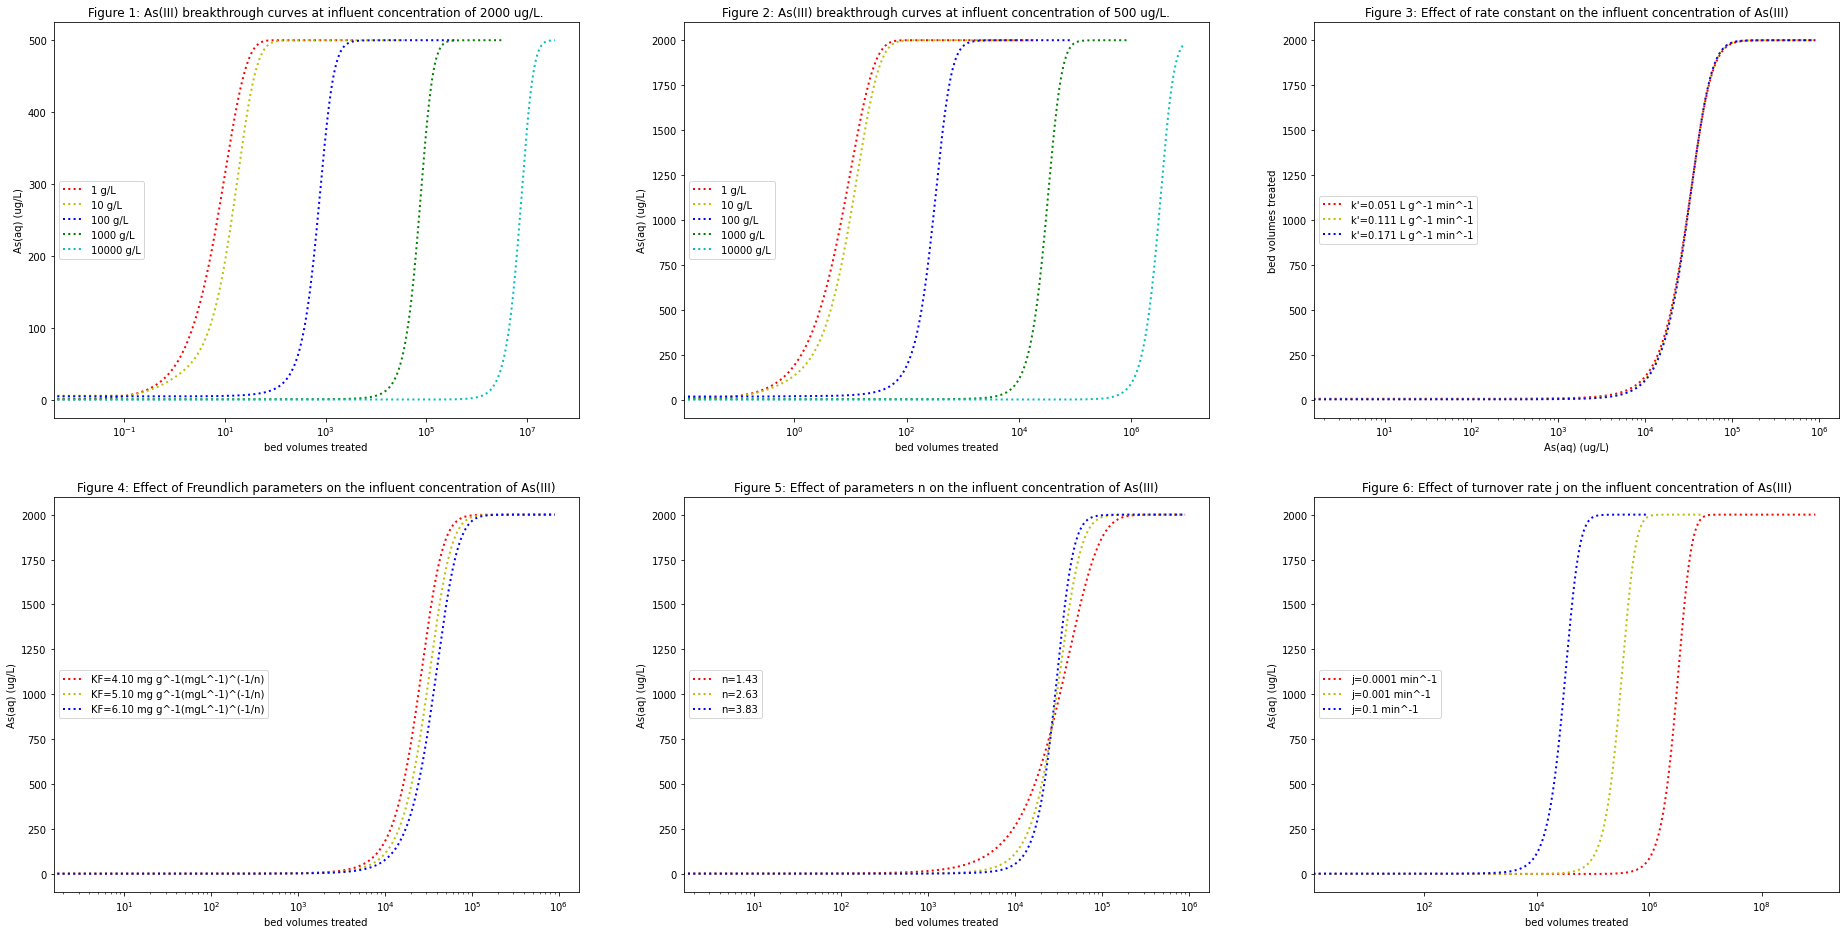

In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(32, 16))



ax[0,1].plot(results_table_1[0][0], results_table_1[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[0,1].plot(results_table_10[0][0], results_table_10[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[0,1].plot(results_table_100[0][0], results_table_100[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[0,1].plot(results_table_1000[0][0], results_table_1000[0][1], color='g', linestyle=':', linewidth=2,
       
        )

ax[0,1].plot(results_table_10000[0][0], results_table_10000[0][1], color='c', linestyle=':', linewidth=2,
      
       )




ax[0,1].get_xaxis().get_major_formatter().set_scientific(False)
ax[0,1].set_title('Figure 2: As(III) breakthrough curves at influent concentration of 500 ug/L.')
ax[0,1].legend(labels=['1 g/L','10 g/L','100 g/L',"1000 g/L","10000 g/L"], loc="center left")
ax[0,1].set_xscale('log')
ax[0,1].set_ylabel('As(aq) (ug/L)')
ax[0,1].set_xlabel('bed volumes treated')


ax[0,0].plot(results_table_1_5[0][0], results_table_1_5[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[0,0].plot(results_table_10_5[0][0], results_table_10_5[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[0,0].plot(results_table_100_5[0][0], results_table_100_5[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[0,0].plot(results_table_1000_5[0][0], results_table_1000_5[0][1], color='g', linestyle=':', linewidth=2,
       
        )

ax[0,0].plot(results_table_10000_5[0][0], results_table_10000_5[0][1], color='c', linestyle=':', linewidth=2,
      
       )


ax[0,0].get_xaxis().get_major_formatter().set_scientific(False)
ax[0,0].set_title('Figure 1: As(III) breakthrough curves at influent concentration of 2000 ug/L.')
ax[0,0].legend(labels=['1 g/L','10 g/L','100 g/L',"1000 g/L","10000 g/L"], loc="center left")
ax[0,0].set_xscale('log')

ax[0,0].set_ylabel('As(aq) (ug/L)')
ax[0,0].set_xlabel('bed volumes treated')


ax[0,2].plot(results_rc_0051[0][0], results_rc_0051[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[0,2].plot(results_rc_0111[0][0], results_rc_0111[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[0,2].plot(results_rc_0171[0][0], results_rc_0171[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[0,2].get_xaxis().get_major_formatter().set_scientific(False)
ax[0,2].set_title('Figure 3: Effect of rate constant on the influent concentration of As(III)')
ax[0,2].legend(labels=["k'=0.051 L g^-1 min^-1","k'=0.111 L g^-1 min^-1","k'=0.171 L g^-1 min^-1"], loc="center left")
ax[0,2].set_xscale('log')

ax[0,2].set_xlabel('As(aq) (ug/L)')
ax[0,2].set_ylabel('bed volumes treated')


ax[1,0].plot(results_F_410[0][0], results_F_410[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[1,0].plot(results_F_510[0][0], results_F_510[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[1,0].plot(results_F_610[0][0], results_F_610[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[1,0].get_xaxis().get_major_formatter().set_scientific(False)
ax[1,0].set_title('Figure 4: Effect of Freundlich parameters on the influent concentration of As(III)')
ax[1,0].legend(labels=["KF=4.10 mg g^-1(mgL^-1)^(-1/n)","KF=5.10 mg g^-1(mgL^-1)^(-1/n)","KF=6.10 mg g^-1(mgL^-1)^(-1/n)"], loc="center left")
ax[1,0].set_xscale('log')

ax[1,0].set_ylabel('As(aq) (ug/L)')
ax[1,0].set_xlabel('bed volumes treated')




ax[1,1].plot(results_n_143[0][0], results_n_143[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[1,1].plot(results_n_263[0][0], results_n_263[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[1,1].plot(results_n_383[0][0], results_n_383[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[1,1].get_xaxis().get_major_formatter().set_scientific(False)
ax[1,1].set_title('Figure 5: Effect of parameters n on the influent concentration of As(III)')
ax[1,1].legend(labels=["n=1.43","n=2.63","n=3.83"], loc="center left")
ax[1,1].set_xscale('log')

ax[1,1].set_ylabel('As(aq) (ug/L)')
ax[1,1].set_xlabel('bed volumes treated')




ax[1,2].plot(results_j_0001[0][0], results_j_0001[0][1], color='r', linestyle=':', linewidth=2,
        
        )

ax[1,2].plot(results_j_001[0][0], results_j_001[0][1], color='y', linestyle=':', linewidth=2,
        
        )

ax[1,2].plot(results_j_01[0][0], results_j_01[0][1], color='b', linestyle=':', linewidth=2,
       
       )

ax[1,2].get_xaxis().get_major_formatter().set_scientific(False)
ax[1,2].set_title('Figure 6: Effect of turnover rate j on the influent concentration of As(III)')
ax[1,2].legend(labels=["j=0.0001 min^-1","j=0.001 min^-1","j=0.1 min^-1"], loc="center left")
ax[1,2].set_xscale('log')




ax[1,2].set_ylabel('As(aq) (ug/L)')
ax[1,2].set_xlabel('bed volumes treated')




# Adsorbents required to treatment

As boundary conditions for the volume of potable water required, we considered the needs of a rural family in West Bengal, India, with an average of 5.7 people per household . The WHO South-East Asia Technical Office reports that 7 L of water is required per person per day (4 L per capita per day (Lpcd) for drinking and 3 Lpcd for food preparation) . These two figures give a requirement of 40 L day−1 potable water per household. This is equivalent to 14,600 L per year per household, and where C0 = 500 μg L−1 As(III).

In [ ]:

def Adsorbents_required(C_in1=500, Cs_in=100, j_flow=0.001, ord_in=2, isotherms1="Freundlich",
                        k_in1=0.1111, KF_in1=5.10, n_in1=2.63, Qmax_in1=29.44, KL_in1=0.11):
    number_of_experiments = 7
    Cs_col_cf = [0] * number_of_experiments
    for i in range(number_of_experiments):
        Cs_col_cf[i] = Cs_in * 10 ** (i - 4)

    _, counter_10000 = Result_Processing(j_flow, C_in1, Cs_col_cf[6], False, ord_in, isotherms1,
                                            k_in1, KF_in1, n_in1, Qmax_in1, KL_in1)
    _, counter_1000 = Result_Processing(j_flow, C_in1, Cs_col_cf[5], False, ord_in, isotherms1,
                                           k_in1, KF_in1, n_in1, Qmax_in1, KL_in1)
    _, counter_100 = Result_Processing(j_flow, C_in1, Cs_col_cf[4], False, ord_in, isotherms1,
                                          k_in1, KF_in1, n_in1, Qmax_in1, KL_in1)
    _, counter_10 = Result_Processing(j_flow, C_in1, Cs_col_cf[3], False, ord_in, isotherms1,
                                         k_in1, KF_in1, n_in1, Qmax_in1, KL_in1)
    _, counter_1 = Result_Processing(j_flow, C_in1, Cs_col_cf[2], False, ord_in, isotherms1,
                                        k_in1, KF_in1, n_in1, Qmax_in1, KL_in1)
    ads = Cs_col_cf[2:]

    result_counter = [counter_1, counter_10, counter_100, counter_1000, counter_10000]
    results = [0] * len(result_counter)
    for i in range(len(result_counter)):
        if result_counter[i] == 0:
            result_counter[i] = 0.0001
        results[i] = (365 / result_counter[i]) * ads[i] * 0.001 * 40

    return min(results)


## Section 7
All other conditions being equal, vary the value of the rate constant and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_rc_cf=[Adsorbents_required(k_in1=0.0111),Adsorbents_required(k_in1=0.1111),Adsorbents_required(k_in1=0.2111)]

## Section 8

All other conditions being equal, vary the value of the Freundlich parameters and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_KF_cf=[Adsorbents_required (KF_in1=4.10),Adsorbents_required (KF_in1=5.10),Adsorbents_required (KF_in1=6.10)]

## Section 9
All other conditions being equal, vary the value of the parameters n and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_n_cf=[Adsorbents_required (n_in1=1.63),Adsorbents_required (n_in1=2.63),Adsorbents_required (n_in1=3.63)]

## Section 10
Number of adsorbents required to treat solutions with different concentrations of arsenic

In [ ]:
result_Cin_cf=[Adsorbents_required (C_in1=500),Adsorbents_required (C_in1=1000),Adsorbents_required (C_in1=2000),Adsorbents_required (C_in1=3000)]

Visualising the comparison results, the Figures 7 to 10 correspond to sections 7 to 10.

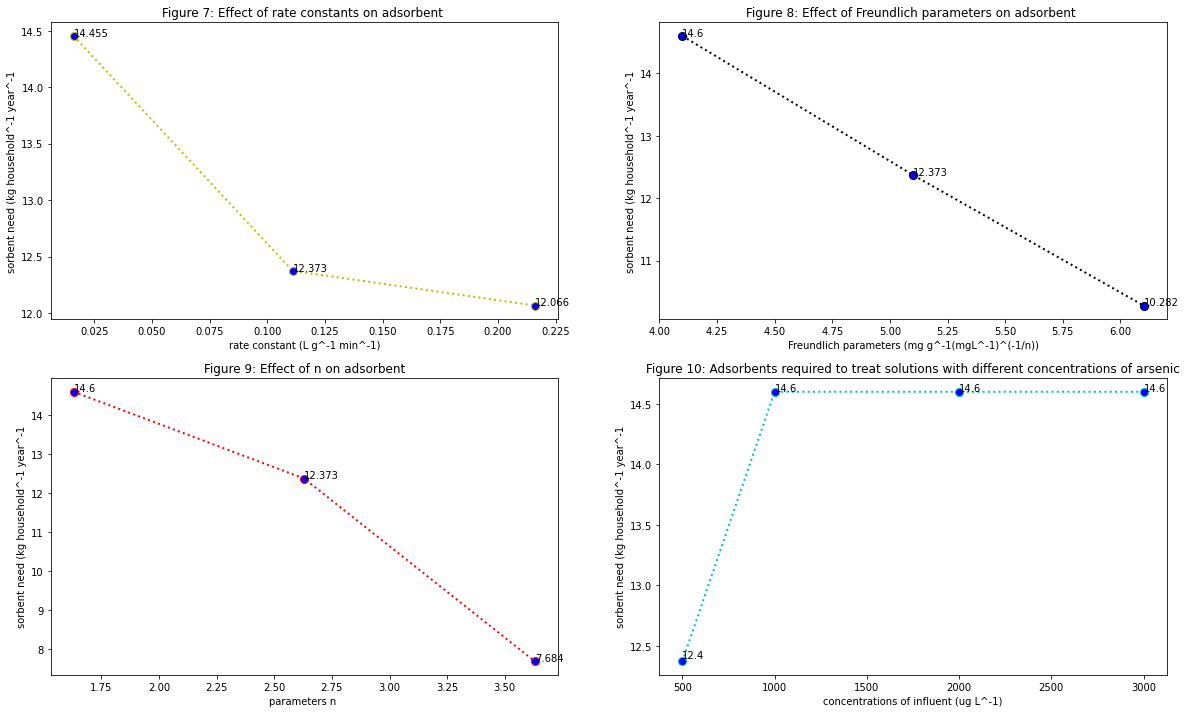

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 12))

# rate constant(k')=[0.016,0.111,0.216]
###########################################
k_cf=[0.016,0.111,0.216]

ax[0, 0].plot(k_cf, result_rc_cf, color='y', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8 )

for a, b in zip(k_cf, result_rc_cf):
    ax[0, 0].text(round(a,3), round(b,3), round(b,3), fontsize=10)


ax[0,0].set_title('Figure 7: Effect of rate constants on adsorbent ')
ax[0,0].set_xlabel('rate constant (L g^-1 min^-1)')
ax[0,0].set_ylabel('sorbent need (kg household^-1 year^-1')

# Freundlich parameters(KF)=[4.10,5.10,6.10]
###########################################
KF_cf=[4.10,5.10,6.10]

ax[0, 1].plot(KF_cf, result_KF_cf, color='k', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)

for a, b in zip(KF_cf, result_KF_cf):
    ax[0, 1].text(round(a,3), round(b,3), round(b,3), fontsize=10)

ax[0,1].set_title('Figure 8: Effect of Freundlich parameters on adsorbent ')
ax[0,1].set_xlabel('Freundlich parameters (mg g^-1(mgL^-1)^(-1/n))')
ax[0,1].set_ylabel('sorbent need (kg household^-1 year^-1')


# n=[1.63,2.63,3.63]
###########################################

n_cf=[1.63,2.63,3.63]

ax[1, 0].plot(n_cf, result_n_cf, color='r', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)
for i, j in zip(n_cf, result_n_cf):
    ax[1, 0].text(round(i,3), round(j,3), round(j,3),  fontsize=10)

ax[1,0].set_title('Figure 9: Effect of n on adsorbent')
ax[1,0].set_xlabel('parameters n ')
ax[1,0].set_ylabel('sorbent need (kg household^-1 year^-1')


# days=365 Cs=[1,10,100,1000,10000] C0=[500,1000,2000,3000]
###########################################

Cin_cf=[500,1000,2000,3000]
ax[1, 1].plot(Cin_cf, result_Cin_cf, color='c', linestyle=':', linewidth=2,marker='o',
         markerfacecolor='blue', markersize=8 )
for a, b in zip(Cin_cf, result_Cin_cf):
    ax[1, 1].text(round(a,1), round(b,1), round(b,1), fontsize=10)

ax[1,1].set_title('Figure 10: Adsorbents required to treat solutions with different concentrations of arsenic')
ax[1,1].set_xlabel('concentrations of influent (ug L^-1)')
ax[1,1].set_ylabel('sorbent need (kg household^-1 year^-1')


plt.show()

## Section 11
Compare the first order Langmuir kinetic energy adsorption equation, compare the second order Langmuir kinetic energy adsorption equation, the first order Freundlich kinetic energy adsorption equation, and the second order Freundlich kinetic energy adsorption equation under the same conditions


In [ ]:
results_table_1000_1,counter_10000=Result_Processing (0.1,500,1000,ord_in=1,isotherms="Langmuir")
results_table_1000_2,counter_10000=Result_Processing (0.1,500,1000,isotherms="Langmuir")
results_table_1000_3,counter_10000=Result_Processing (0.1,500,1000)
results_table_1000_4,counter_10000=Result_Processing (0.1,500,1000,ord_in=1)

Visualising the comparison results, the Figures 11 correspond to sections 11.

Text(0.5, 0, 'bed volumes treated')

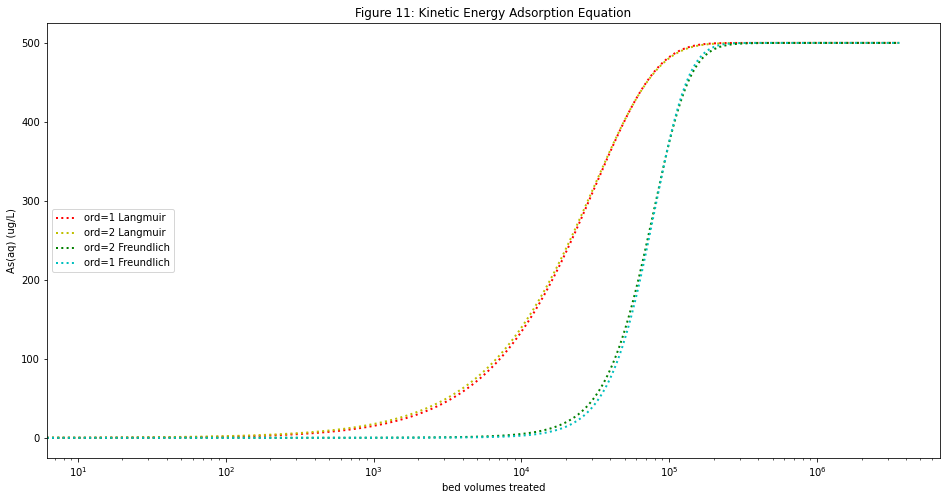

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8))



ax.plot(results_table_1000_1[0][0], results_table_1000_1[0][1], color='r', linestyle=':', linewidth=2,
        
        )
ax.plot(results_table_1000_2[0][0], results_table_1000_2[0][1], color='y', linestyle=':', linewidth=2,
        
        )
ax.plot(results_table_1000_3[0][0], results_table_1000_3[0][1], color='g', linestyle=':', linewidth=2,
        
        )
ax.plot(results_table_1000_4[0][0], results_table_1000_4[0][1], color='c', linestyle=':', linewidth=2,
        
        )

ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_title('Figure 11: Kinetic Energy Adsorption Equation')
ax.legend(labels=['ord=1 Langmuir','ord=2 Langmuir','ord=2 Freundlich',"ord=1 Freundlich"], loc="center left")
ax.set_xscale('log')
ax.set_ylabel('As(aq) (ug/L)')
ax.set_xlabel('bed volumes treated')

## Section 12
Vary the value of the Kinetic Energy Adsorption Equation and analyse the effect of the rate constant on the amount of adsorbent used

In [ ]:
result_LF_cf=[Adsorbents_required(ord_in=1,isotherms1="Langmuir"),
              Adsorbents_required(isotherms1="Langmuir",ord_in=2),
              Adsorbents_required(ord_in=1),
              Adsorbents_required()]

Visualising the comparison results, the Figures 12 correspond to sections 12

Text(0, 0.5, 'sorbent need (kg household^-1 year^-1')

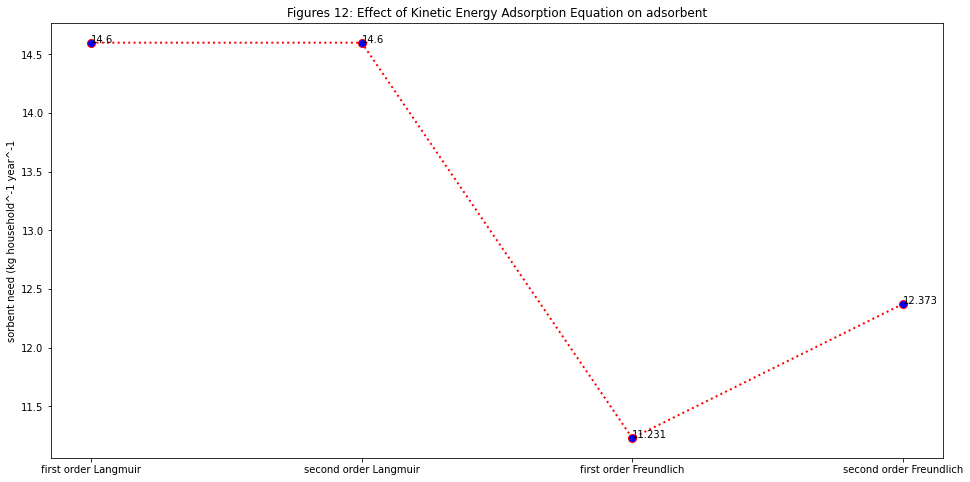

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(['first order Langmuir','second order Langmuir','first order Freundlich',"second order Freundlich"], result_LF_cf, color='r', linestyle=':', linewidth=2, marker='o',
         markerfacecolor='blue', markersize=8)
for i, j in zip(['first order Langmuir','second order Langmuir','first order Freundlich',"second order Freundlich"], result_LF_cf):
    ax.text(i, round(j,3), round(j,3),  fontsize=10)

ax.set_title('Figures 12: Effect of Kinetic Energy Adsorption Equation on adsorbent')

ax.set_ylabel('sorbent need (kg household^-1 year^-1')